In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import matthews_corrcoef, accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from tqdm.notebook import tqdm, tnrange
np.set_printoptions(suppress=True)


from classification_utils import *
pd.set_option('display.max_columns', None)

In [2]:
rand_state = 1 # random seed used in every place which take a seed as input

Label categories:
* 0 corresponds to 'No trend' 
* 1 corresponds to 'Decreasing trend' 
* 2 corresponds to 'Increasing trend'

In [3]:
class_dict = {0: 'No trend', 1: 'Decreasing trend', 2: 'Increasing trend'}
class_names = ['No trend', 'Decreasing trend', 'Increasing trend']

data = pd.read_csv('cross_sectional_data.csv', index_col=[0])
X , y = encode(data.drop(columns=['ID', 'Labels'])) , data['Labels'].to_numpy()
# Fix missing values
col_list = list(X.columns.values)
X = X.reindex(columns=col_list).fillna(0)
X = X[col_list]
X_numeric = X.iloc[: , :8]

# Standardize numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric, columns=encode(data.drop(columns=['ID', 'Labels'])).columns.values[:8])
X = pd.concat([X_numeric, X.iloc[:, 8:]], axis=1)
X = X.drop(columns=['r2', 'slope']) # remove these two features since they won't be available in case of model deployment

c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Split the data into training and test sets

We then fine-tune the models using sklearn functionality on the training set, so for now we don't create any validation sets.

We are also careful to keep the proportions of labels in the training, testing and validation sets the same. This is quite important since we are dealing with imbalanced labels.

In [4]:
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state, stratify = y)

## Logistic regression model

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)


lr_C_vals = [0.01, 0.1, 0.5, 1, 3, 5, 10, 20, 30, 40, 50, 70, 100, 200, 500, 1000, 2000, 5000, 10_000, 100_000] # L2-regularisation values
log_reg = LogisticRegression(penalty='l2', max_iter=10_000, multi_class='multinomial')
log_reg_grid = {'C' : lr_C_vals}
# Tune model
tuned_log_reg , log_reg_test_mcc = tune_model_and_get_test_mcc(X, y, log_reg, rand_state=rand_state, hyperparam_grid=log_reg_grid, test_size=0.2, print_best_params=True)
# Evaluate on test set
print(f'MCC on test set using Logistic regression: {log_reg_test_mcc :.3f}')
print(f'Accuracy on test set using Logistic regression: {accuracy_score(y_test , tuned_log_reg.predict(X_test)) :.3f}')

{'C': 3}
MCC on test set using Logistic regression: 0.109
Accuracy on test set using Logistic regression: 0.686


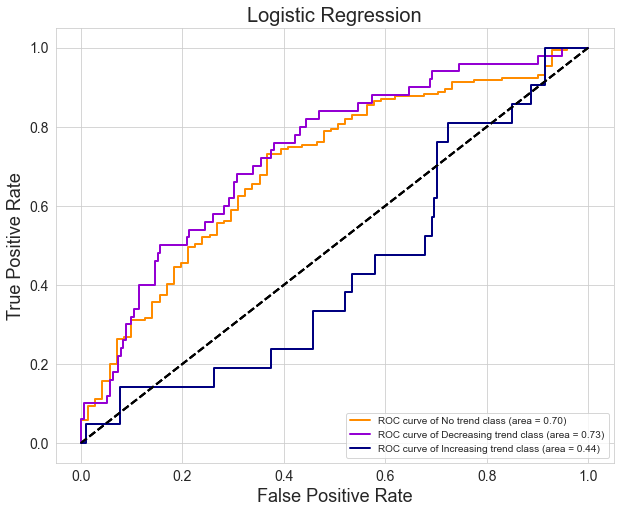

In [9]:
produce_roc(tuned_log_reg.predict_proba(X_test), y_test, class_dict, title='Logistic Regression')

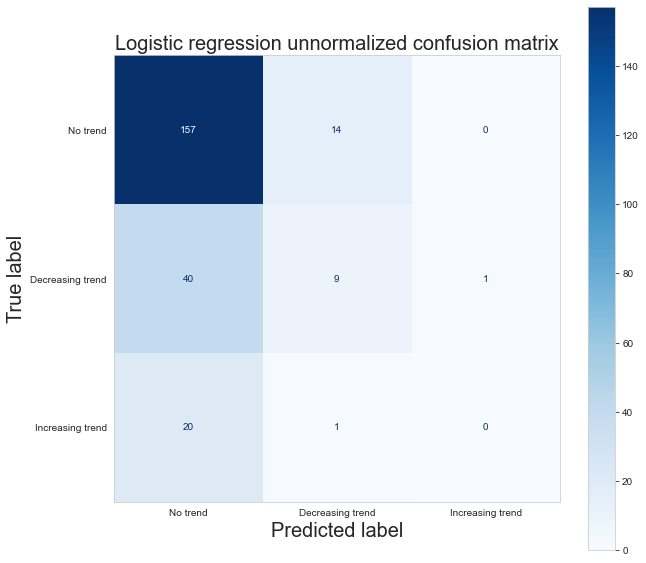

In [7]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axs = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test, tuned_log_reg.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation=0, values_format=None, ax=axs, colorbar=True);
axs.set_title('Logistic regression unnormalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=20)
axs.set_ylabel('True label', fontsize=20)
plt.show()

## Support vector classifier

In [12]:
svm_C_vals = [0.01, 0.1, 0.5, 1, 3, 5, 10, 20, 30, 40, 50, 70, 100, 200, 500, 1000, 2000, 5000, 10_000, 100_000] # regularisation strength constant
rbf_gamma_vals = [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.5, 0.8, 1, 2, 3, 5, 10, 15, 30, 40, 50, 100, 200, 500, 1000, 10_000]
svc_grid = {'C' : svm_C_vals, 'gamma' : rbf_gamma_vals}
svc = SVC(kernel='rbf')

# Tune model
tuned_svc , svc_test_mcc = tune_model_and_get_test_mcc(X, y, svc, rand_state=rand_state, hyperparam_grid=svc_grid, test_size=0.2, print_best_params=True)
# Evaluate on test set
print(f'MCC on test set using SVC: {svc_test_mcc :.3f}')
print(f'Accuracy on test set using SVC: {accuracy_score(y_test , tuned_svc.predict(X_test)) :.3f}')

{'C': 10000, 'gamma': 0.001}
MCC on test set using SVC: 0.218
Accuracy on test set using SVC: 0.719


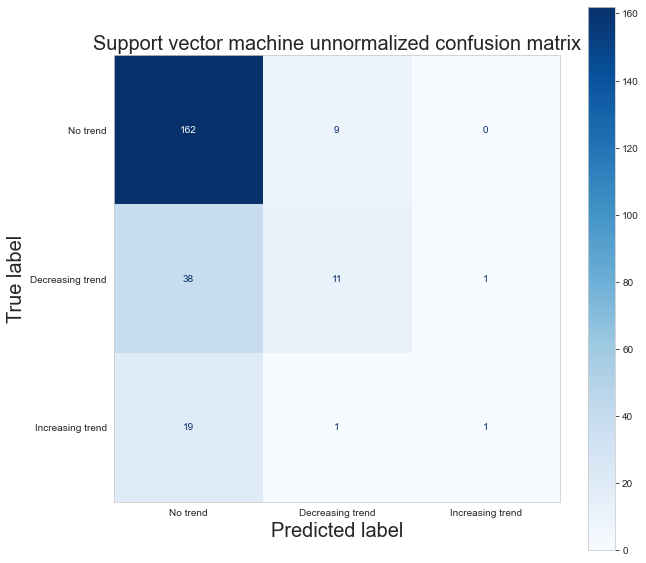

In [13]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axs = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test, tuned_svc.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation=0, values_format=None, ax=axs, colorbar=True);
axs.set_title('Support vector machine unnormalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=20)
axs.set_ylabel('True label', fontsize=20)
plt.show()

## Random Forest classifier

In [3]:
acc_list , mcc_list = [] , []

for z in range(1, 6):

    test_size = 0.20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = z, stratify = y)

    rf_n_est = [100, 200, 300, 400, 500, 1000, 1500, 2000, 5000, 10_000]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    rf_grid = {'n_estimators' : rf_n_est, 'max_depth' : max_depth, 'max_features' : max_features, 'min_samples_split' : min_samples_split}
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=z, n_jobs=-1)

    # Tune model
    tuned_rf , rf_test_mcc = tune_model_and_get_test_mcc(X, y, rf, rand_state=z, hyperparam_grid=rf_grid, test_size=0.2, print_best_params=True)
    # Evaluate on test set
    #print(f'MCC on test set using RF: {rf_test_mcc :.3f}')
    #print(f'Accuracy on test set using RF: {accuracy_score(y_test , tuned_rf.predict(X_test)) :.3f}')

    acc_list.append(accuracy_score(y_test , tuned_rf.predict(X_test)))
    mcc_list.append(rf_test_mcc)

print(np.mean(acc_list))
print(np.std(acc_list))
print('\n')
print(np.mean(mcc_list))
print(np.std(mcc_list))

{'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 300}
{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 100}
{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 500}
{'max_depth': 30, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 500}
{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 100}
0.7190082644628099
0.009778644269586157


0.18930431260372385
0.04568232545691486


In [5]:
rf_n_est = [100, 200, 300, 400, 500, 1000, 1500, 2000, 5000, 10_000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

rf_grid = {'n_estimators' : rf_n_est, 'max_depth' : max_depth, 'max_features' : max_features, 'min_samples_split' : min_samples_split}
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=1, n_jobs=-1)

# Tune model
tuned_rf , rf_test_mcc = tune_model_and_get_test_mcc(X, y, rf, rand_state=rand_state, hyperparam_grid=rf_grid, test_size=0.2, print_best_params=True)
# Evaluate on test set
print(f'MCC on test set using RF: {rf_test_mcc :.3f}')
print(f'Accuracy on test set using RF: {accuracy_score(y_test , tuned_rf.predict(X_test)) :.3f}')

{'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 300}
MCC on test set using RF: 0.247
Accuracy on test set using RF: 0.731


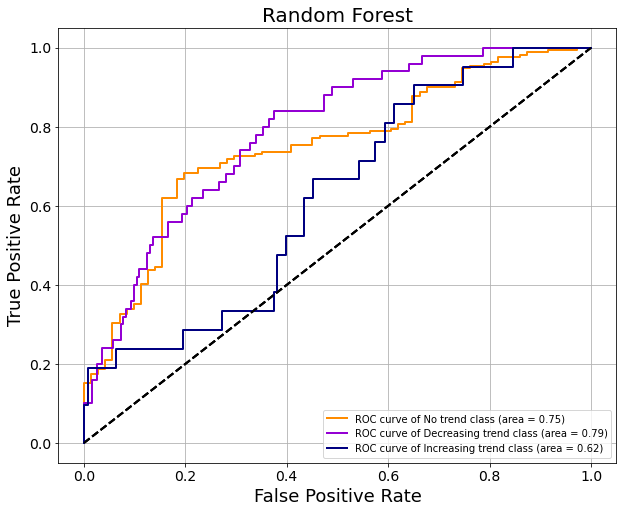

In [6]:
produce_roc(tuned_rf.predict_proba(X_test), y_test, class_dict, title='Random Forest')

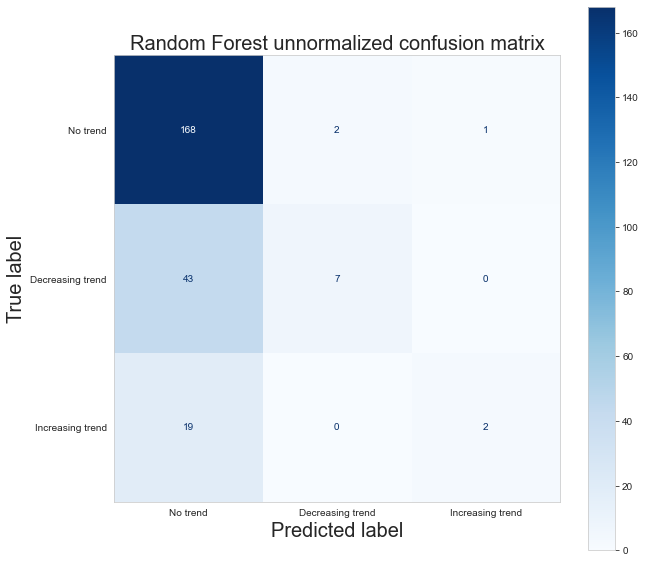

In [7]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axs = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test, tuned_rf.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation=0, values_format=None, ax=axs, colorbar=True);
axs.set_title('Random Forest unnormalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=20)
axs.set_ylabel('True label', fontsize=20)
plt.show()